# This notebook is used to generate the data and analyses of the background section of my master's thesis

In [1]:
# Imports
import numpy
import adaptive_nof1
import pandas
import scipy.stats as stats
import seaborn
import pymc
import arviz
import matplotlib.pyplot as plt
import arviz.labels as azl

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Generate data:
rng = numpy.random.default_rng(42)  # Use a seed to be reproducible

n_patients = 10
n_interventions = 2
intervention_sequence = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]

mean_effect_patients_intervention_1 = rng.normal(1, 0.7, size=n_patients)
mean_effect_patients_intervention_2 = rng.normal(0, 0.7, size=n_patients)

outcomes_intervention_1 = rng.normal(
    mean_effect_patients_intervention_1,
    1,
    size=(5, len(mean_effect_patients_intervention_1)),
)
outcomes_intervention_2 = rng.normal(
    mean_effect_patients_intervention_2,
    1,
    size=(5, len(mean_effect_patients_intervention_2)),
)
df = pandas.concat(
    [
        pandas.DataFrame(outcomes_intervention_1),
        pandas.DataFrame(outcomes_intervention_2),
    ]
)
df["t"] = range(1, 11)
df.set_index("t")
df["intervention"] = intervention_sequence


def print_for_latex(array):
    str = ""
    for element in array:
        str += f"{element:.2f}"
        if element != array[-1]:
            str += "& "
        else:
            str += "\\\\"
    print(str)


print(f"Mean effects 1")
print_for_latex(mean_effect_patients_intervention_1)
print(f"Mean effects 2")
print_for_latex(mean_effect_patients_intervention_2)

Mean effects 1
1.21& 0.27& 1.53& 1.66& -0.37& 0.09& 1.09& 0.78& 0.99& 0.40\\
Mean effects 2
0.62& 0.54& 0.05& 0.79& 0.33& -0.60& 0.26& -0.67& 0.61& -0.03\\


In [3]:
print(outcomes_intervention_1[:, 0])
print(outcomes_intervention_2[:, 0])

print(
    f"Analytical estimate: {stats.norm.cdf(0, 0 - (1.23 - 0.5) , numpy.sqrt(1.0/6 + 1.0/6))}"
)

[ 1.02843959  3.35494956  1.95655613  1.50242135 -0.46956782]
[-0.66010774  1.07235382  1.28096369  0.23741603  1.05000223]
Analytical estimate: 0.8969562314963575


In [20]:
df = df[["t", "intervention", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
list(round(df[0], 2))

[1.03, 3.35, 1.96, 1.5, -0.47, -0.66, 1.07, 1.28, 0.24, 1.05]

In [5]:
# Export the DataFrame to a LaTeX table
latex_table = df.to_latex(index=False, float_format="%.1f")
# Print or save the LaTeX table to a .tex file
print(latex_table)

with open("mt_resources/2-background/background_example_data.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{rrrrrrrrrrrr}
\toprule
t & intervention & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\
\midrule
1 & 1 & 1.0 & -0.4 & 2.7 & 1.5 & -0.8 & -0.3 & 1.6 & 1.1 & 1.4 & 0.8 \\
2 & 1 & 3.4 & -0.1 & 1.0 & 0.8 & 0.3 & 1.2 & 1.0 & -0.1 & 0.2 & 1.1 \\
3 & 1 & 2.0 & 0.8 & 0.9 & 1.9 & -0.2 & 0.3 & 2.0 & 1.0 & 1.7 & 0.5 \\
4 & 1 & 1.5 & 0.9 & 0.1 & 1.3 & -0.8 & -0.6 & 0.8 & 2.3 & 0.1 & 1.4 \\
5 & 1 & -0.5 & -0.1 & 1.7 & 2.2 & 0.3 & 0.9 & 0.7 & 0.3 & 1.8 & 0.2 \\
6 & 2 & -0.7 & -0.6 & -0.9 & 1.3 & 0.5 & 0.1 & -0.2 & -0.5 & 1.2 & -0.3 \\
7 & 2 & 1.1 & -0.1 & -0.3 & 0.4 & -0.9 & -0.1 & -0.2 & -0.7 & 1.1 & 0.4 \\
8 & 2 & 1.3 & 0.4 & -0.4 & 0.7 & -1.4 & -2.0 & -1.1 & -1.7 & 1.0 & -0.9 \\
9 & 2 & 0.2 & 1.8 & -0.3 & 1.5 & -0.6 & -0.8 & -0.7 & -1.0 & 1.5 & -1.8 \\
10 & 2 & 1.1 & 0.8 & -0.5 & -0.7 & 0.4 & -1.1 & 0.5 & -0.6 & 2.2 & -0.3 \\
\bottomrule
\end{tabular}



In [6]:
# Plot the posterior of m_{0,0} and m_{0, 1} given the condition on only the data for patient one
n = numpy.array([5.0, 5.0])
sigma_squared_0 = numpy.array([1.0, 1.0])
sigma_squared = numpy.array([1.0, 1.0])
sigma_squared_n = 1 / ((n / sigma_squared) + (1 / sigma_squared_0))
mu_0 = numpy.array([0, 0])

means_of_observations = df.groupby("intervention")[0].mean().to_numpy()

mu_n = sigma_squared_n * (
    (mu_0 / sigma_squared_0) + ((5 * means_of_observations) / sigma_squared)
)
print(f"mu_n {mu_n}")
print(f"sigma_squared_n {sigma_squared_n}")

mu_n [1.2287998  0.49677134]
sigma_squared_n [0.16666667 0.16666667]


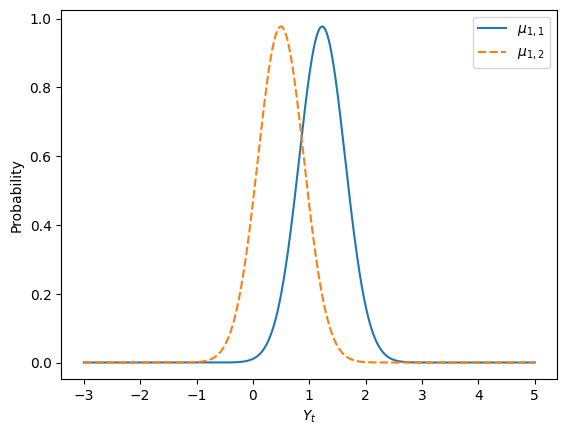

In [7]:
# plot posterior predictive for mu
x = numpy.linspace(-3, 5.0, 10000)
y_0 = stats.norm.pdf(x, mu_n[0], numpy.sqrt(sigma_squared_n[0]))
y_1 = stats.norm.pdf(x, mu_n[1], numpy.sqrt(sigma_squared_n[1]))
dff = pandas.DataFrame({"$Y_t$": x, "$\mu_{1,1}$": y_0, "$\mu_{1,2}$": y_1})
dff.set_index("$Y_t$", inplace=True)
seaborn.lineplot(dff)
plt.ylabel("Probability")
plt.savefig("mt_resources/2-background/mean_posteriors.pdf", bbox_inches="tight")

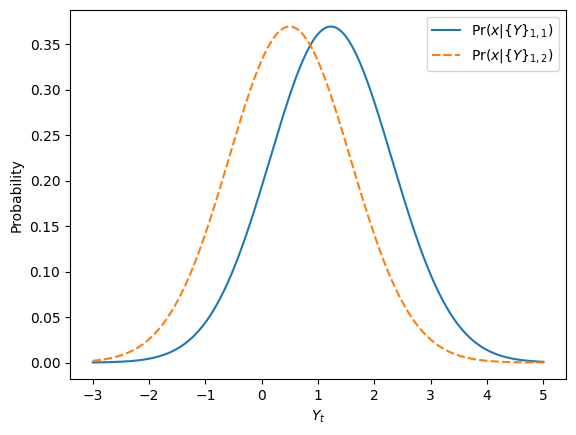

In [8]:
# plot posterior predictive for outcome Pr(x | D)
x = numpy.linspace(-3, 5.0, 10000)
y_0 = stats.norm.pdf(x, mu_n[0], numpy.sqrt(sigma_squared_n[0] + sigma_squared[0]))
y_1 = stats.norm.pdf(x, mu_n[1], numpy.sqrt(sigma_squared_n[1] + sigma_squared[0]))
dff = pandas.DataFrame(
    {"$Y_t$": x, "$\Pr(x | \{Y\}_{1,1})$": y_0, "$\Pr(x | \{Y\}_{1,2})$": y_1}
)
dff.set_index("$Y_t$", inplace=True)
seaborn.lineplot(dff)
plt.ylabel("Probability")
plt.savefig("mt_resources/2-background/outcome_posteriors.pdf", bbox_inches="tight")

In [9]:
# Model code for one patient
model = pymc.Model()
with model:
    intervention_index = pymc.MutableData(
        "intervention_index", pymc.intX(df["intervention"] - 1), dims="observation"
    )
    patient_index = 0
    mu_ik = pymc.Normal("mu_ik", mu=0, sigma=1, dims="intervention", shape=2)
    outcome = pymc.Normal(
        "outcome",
        mu=mu_ik[intervention_index],
        observed=df[patient_index],
        sigma=1,
        dims="observation",
        shape=len(df[patient_index]),
    )
    trace = pymc.sample(2000, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.


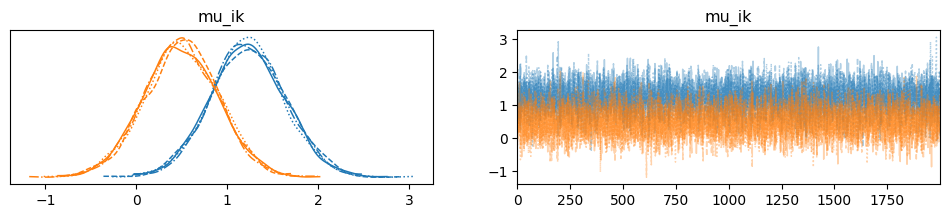

In [10]:
axes = arviz.plot_trace(trace)
plt.savefig("mt_resources/2-background/plot_trace.pdf", bbox_inches="tight")

In [11]:
arviz.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ik[0],1.228,0.410,0.463,2.002,0.005,0.003,8170.0,5332.0,1.0
mu_ik[1],0.495,0.406,-0.260,1.274,0.004,0.004,8196.0,6263.0,1.0


In [15]:
from scipy.stats import norm
norm.ppf(0.97, loc=1.23, scale=0.41)

2.001125379342013

In [12]:
max_indices = numpy.ravel(trace["posterior"]["mu_ik"].argmax(dim="intervention"))

bin_counts = numpy.bincount(max_indices, minlength=2)
print(f"Sample Estimate: {bin_counts[0] / numpy.sum(bin_counts)}")

print(mu_n)
print(sigma_squared_n)
print(
    f"Analytical estimate: {stats.norm.cdf(0, 0 -(mu_n[0] -mu_n[1]) , numpy.sqrt(sigma_squared_n[0] + sigma_squared_n[1]))}"
)

Sample Estimate: 0.899
[1.2287998  0.49677134]
[0.16666667 0.16666667]
Analytical estimate: 0.8975850419335487


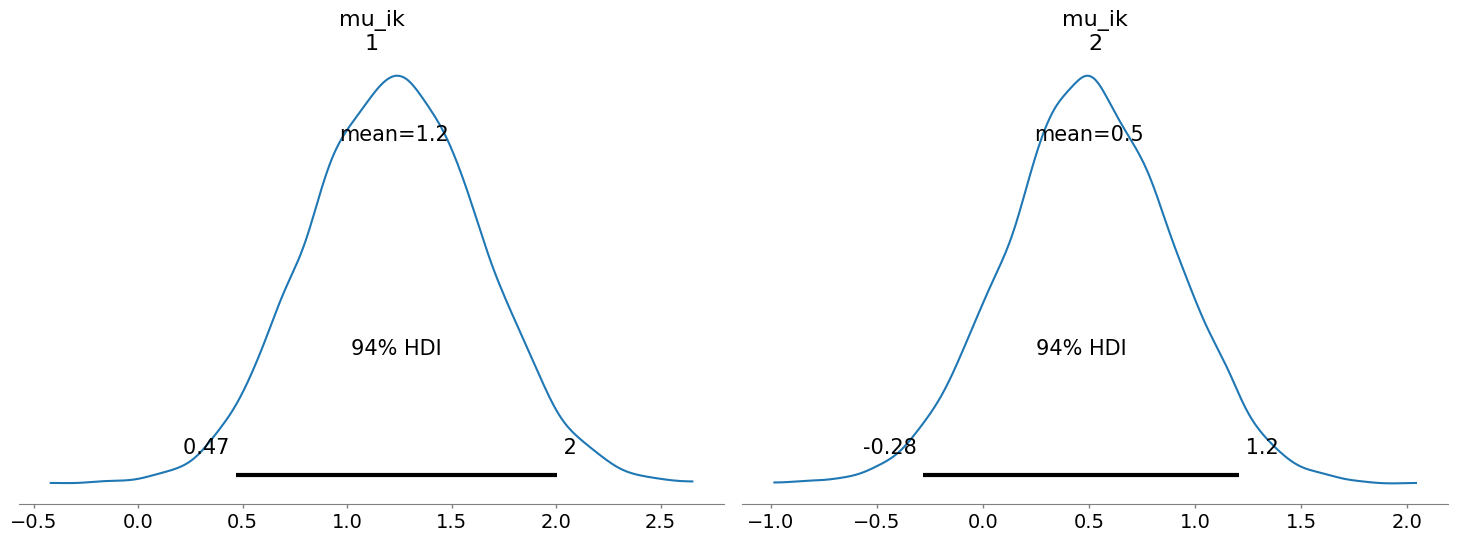

In [13]:
index_plus_one_dict = {i: i + 1 for i in range(100)}

coord_map = {"intervention": index_plus_one_dict, "patient": index_plus_one_dict}
labeller = azl.MapLabeller(coord_map=coord_map)

coords = {"intervention": [0, 1]}
arviz.plot_posterior(trace, var_names=("mu_ik"), coords=coords, labeller=labeller)
plt.tight_layout()
plt.savefig("mt_resources/2-background/non-pooled-patient-1.pdf", bbox_inches="tight")

In [14]:
pooled_df = pandas.melt(
    df, id_vars=["t", "intervention"], var_name="patient_id", value_name="outcome"
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_intervention, mu_patient_intervention]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


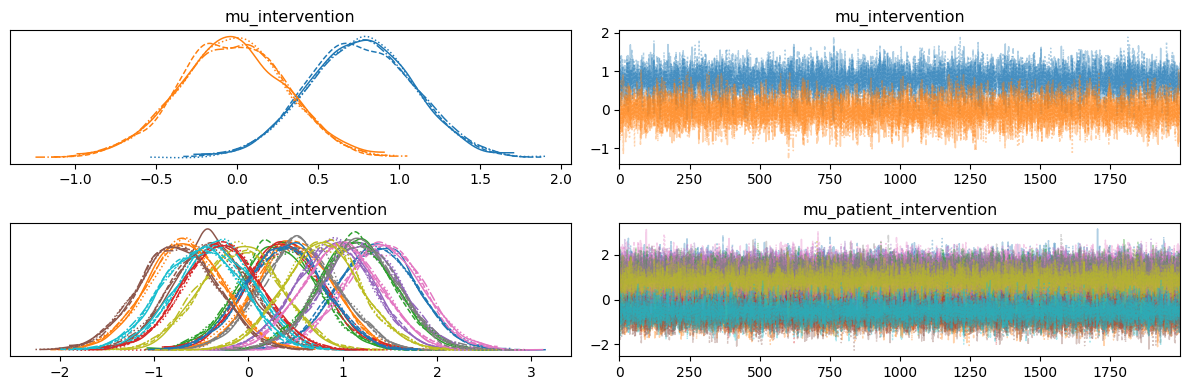

In [15]:
# Pooled mu_ik

# Model code for pooled version
model = pymc.Model()
with model:
    intervention_index = pymc.MutableData(
        "intervention_index",
        pymc.intX(pooled_df["intervention"] - 1),
        dims="observation",
    )
    patient_index = pymc.MutableData(
        "patient_index", pymc.intX(pooled_df["patient_id"]), dims="observation"
    )
    mu_intervention = pymc.Normal(
        "mu_intervention", mu=0, sigma=1, dims="intervention", shape=2
    )
    mu_intervention_patient = pymc.Normal(
        "mu_patient_intervention",
        mu=mu_intervention,
        sigma=1,
        dims=("patient", "intervention"),
        shape=(10, 2),
    )
    outcome = pymc.Normal(
        "outcome",
        mu=mu_intervention_patient[patient_index, intervention_index],
        observed=pooled_df["outcome"],
        sigma=1,
        dims="observation",
        shape=len(pooled_df["outcome"]),
    )
    trace = pymc.sample(2000, progressbar=False)
arviz.plot_trace(trace)
plt.tight_layout()
plt.savefig("mt_resources/2-background/plot_trace_pooled.pdf", bbox_inches="tight")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_intervention, mu_patient_intervention]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


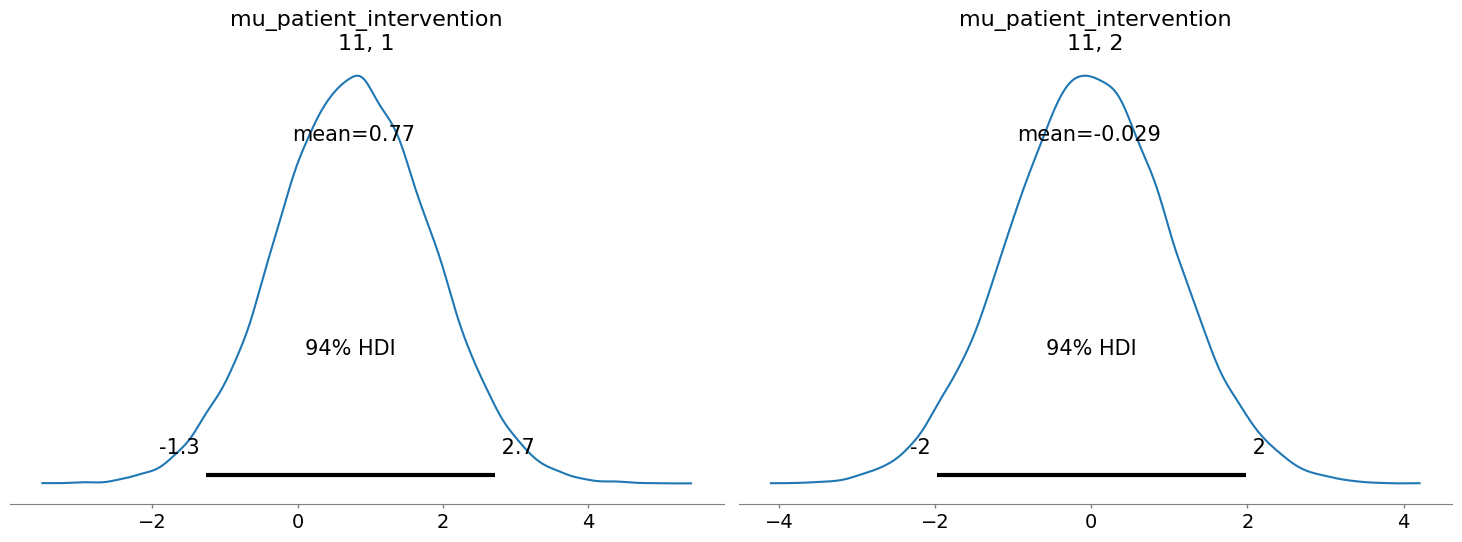

In [16]:
# Patient who is out of sample with data from other patients
model = pymc.Model()
with model:
    intervention_index = pymc.MutableData(
        "intervention_index",
        pymc.intX(pooled_df["intervention"] - 1),
        dims="observation",
    )
    patient_index = pymc.MutableData(
        "patient_index", pymc.intX(pooled_df["patient_id"]), dims="observation"
    )
    mu_intervention = pymc.Normal(
        "mu_intervention", mu=0, sigma=1, dims="intervention", shape=2
    )
    mu_intervention_patient = pymc.Normal(
        "mu_patient_intervention",
        mu=mu_intervention,
        sigma=1,
        dims=("patient", "intervention"),
        shape=(11, 2),
    )
    outcome = pymc.Normal(
        "outcome",
        mu=mu_intervention_patient[patient_index, intervention_index],
        observed=pooled_df["outcome"],
        sigma=1,
        dims="observation",
        shape=len(pooled_df["outcome"]),
    )
    trace = pymc.sample(10000, progressbar=False)
coords = {"intervention": [0, 1], "patient": [10]}
arviz.plot_posterior(
    trace, var_names=("mu_patient_intervention"), coords=coords, labeller=labeller
)
plt.tight_layout()
plt.savefig(
    "mt_resources/2-background/out-of-sample-pooled-posterior-with-data.pdf",
    bbox_inches="tight",
)

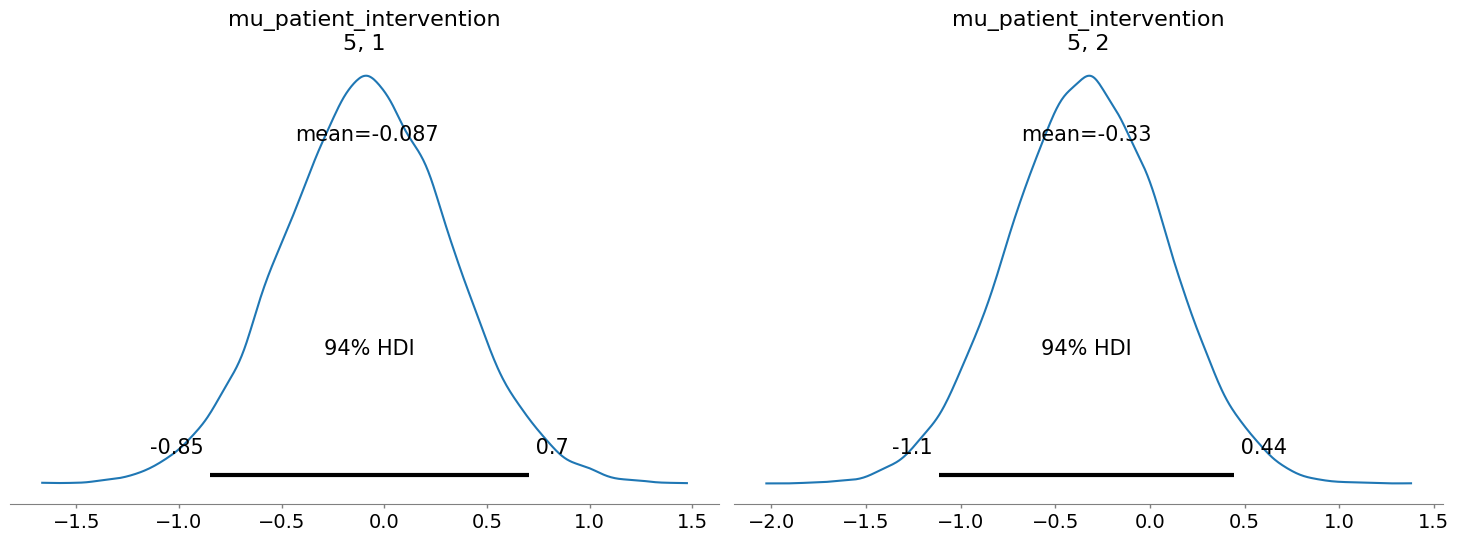

In [17]:
# Patient 5 with data available
coords = {"intervention": [0, 1], "patient": [4]}
arviz.plot_posterior(
    trace, var_names=("mu_patient_intervention"), coords=coords, labeller=labeller
)
plt.tight_layout()
plt.savefig(
    "mt_resources/2-background/pooled-patient-5-with-data.pdf", bbox_inches="tight"
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_intervention, mu_patient_intervention]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.


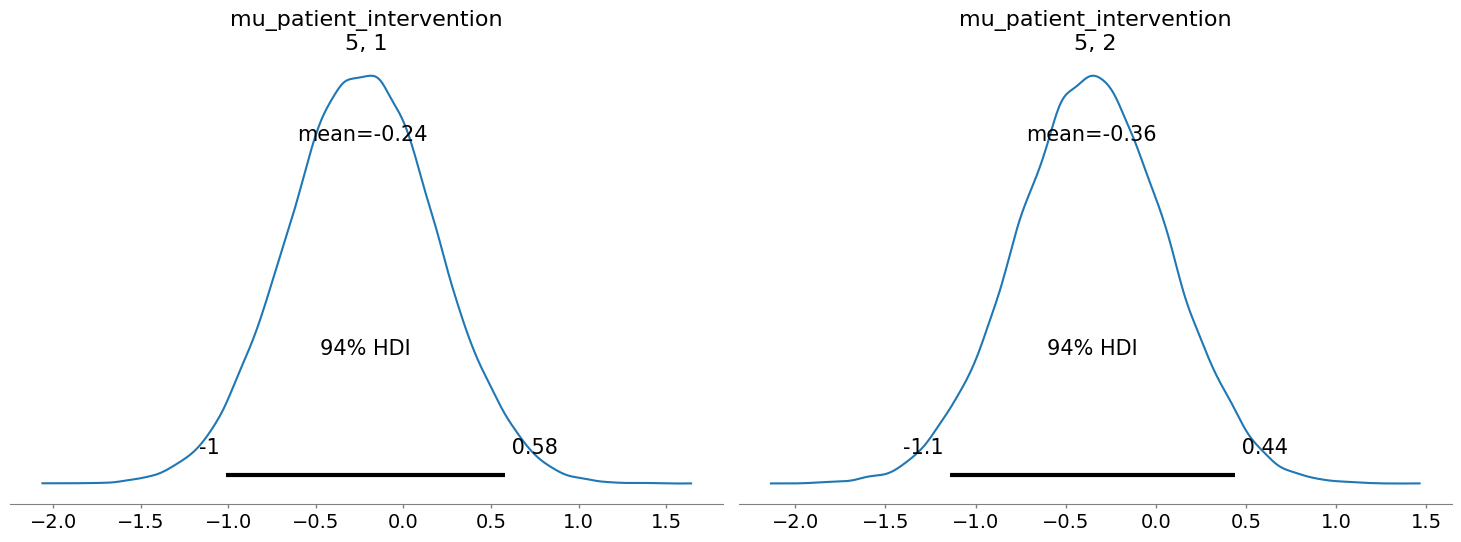

In [18]:
# Patient 1 with no data from other patients
patient_one_df = pooled_df[pooled_df["patient_id"] == 4]
# print(patient_one_df)
model = pymc.Model()
with model:
    intervention_index = pymc.MutableData(
        "intervention_index",
        pymc.intX(patient_one_df["intervention"] - 1),
        dims="observation",
    )
    patient_index = pymc.MutableData(
        "patient_index", pymc.intX(patient_one_df["patient_id"]), dims="observation"
    )
    mu_intervention = pymc.Normal(
        "mu_intervention", mu=0, sigma=1, dims="intervention", shape=2
    )
    mu_intervention_patient = pymc.Normal(
        "mu_patient_intervention",
        mu=mu_intervention,
        sigma=1,
        dims=("patient", "intervention"),
        shape=(12, 2),
    )
    outcome = pymc.Normal(
        "outcome",
        mu=mu_intervention_patient[patient_index, intervention_index],
        observed=patient_one_df["outcome"],
        sigma=1,
        dims="observation",
        shape=len(patient_one_df["outcome"]),
    )
    trace = pymc.sample(10000, progressbar=False)
coords = {"intervention": [0, 1], "patient": [4]}
arviz.plot_posterior(
    trace, var_names=("mu_patient_intervention"), coords=coords, labeller=labeller
)
plt.tight_layout()
plt.savefig(
    "mt_resources/2-background/pooled-patient-5-no-data.pdf", bbox_inches="tight"
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_intervention, mu_patient_intervention]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


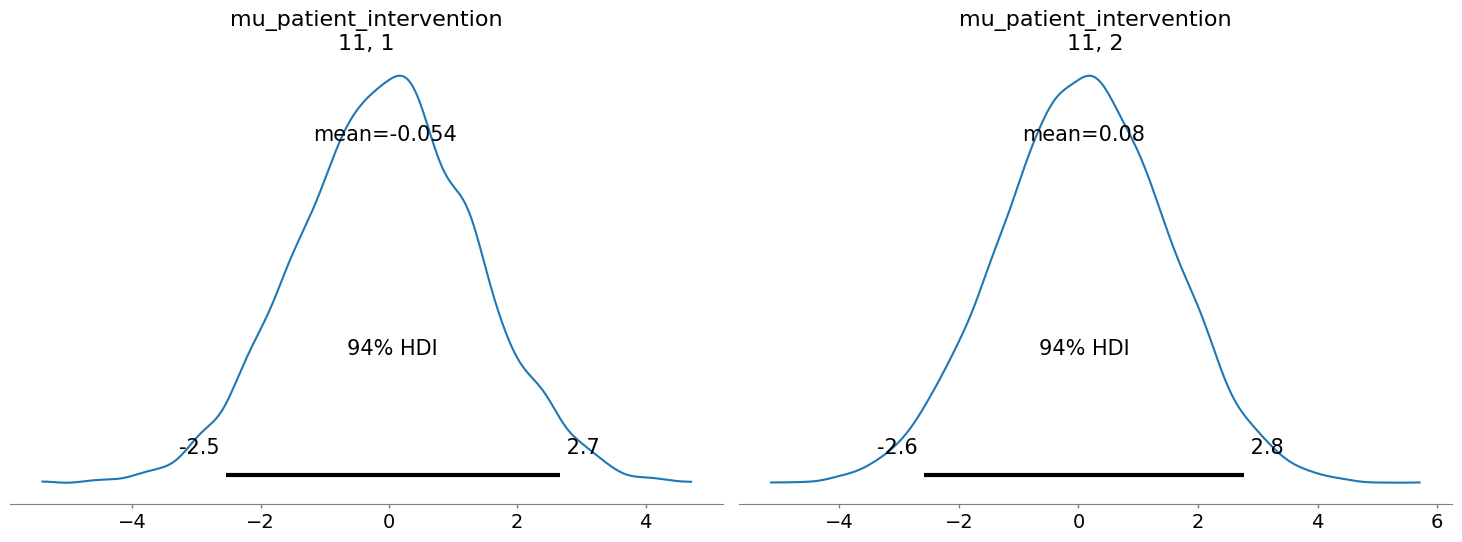

In [19]:
# Patient who is out of sample with no data from other patients
model = pymc.Model()
with model:
    intervention_index = pymc.MutableData(
        "intervention_index", pymc.intX([]), dims="observation"
    )
    patient_index = pymc.MutableData("patient_index", pymc.intX([]), dims="observation")
    mu_intervention = pymc.Normal(
        "mu_intervention", mu=0, sigma=1, dims="intervention", shape=2
    )
    mu_intervention_patient = pymc.Normal(
        "mu_patient_intervention",
        mu=mu_intervention,
        sigma=1,
        dims=("patient", "intervention"),
        shape=(11, 2),
    )
    outcome = pymc.Normal(
        "outcome",
        mu=mu_intervention_patient[patient_index, intervention_index],
        observed=[],
        sigma=1,
        dims="observation",
        shape=len([]),
    )
    trace = pymc.sample(2000, progressbar=False)
coords = {"intervention": [0, 1], "patient": [10]}
arviz.plot_posterior(
    trace, var_names=("mu_patient_intervention"), coords=coords, labeller=labeller
)
plt.tight_layout()
plt.savefig(
    "mt_resources/2-background/out-of-sample-pooled-posterior-with-no-data.pdf",
    bbox_inches="tight",
)

In [20]:
arviz.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_intervention[0],-0.060,0.973,-1.873,1.758,0.027,0.019,1264.0,2065.0,1.0
mu_intervention[1],0.073,0.988,-1.733,1.870,0.030,0.021,1121.0,2142.0,1.0
"mu_patient_intervention[0, 0]",-0.049,1.405,-2.758,2.454,0.032,0.023,1930.0,3262.0,1.0
"mu_patient_intervention[0, 1]",0.065,1.409,-2.683,2.627,0.033,0.023,1811.0,3494.0,1.0
"mu_patient_intervention[1, 0]",-0.062,1.384,-2.722,2.455,0.030,0.021,2109.0,3803.0,1.0
"mu_patient_intervention[1, 1]",0.079,1.408,-2.529,2.711,0.033,0.023,1850.0,3622.0,1.0
"mu_patient_intervention[2, 0]",-0.060,1.411,-2.878,2.445,0.030,0.021,2191.0,3658.0,1.0
"mu_patient_intervention[2, 1]",0.075,1.412,-2.599,2.638,0.033,0.023,1821.0,3565.0,1.0
"mu_patient_intervention[3, 0]",-0.055,1.407,-2.613,2.658,0.030,0.021,2144.0,3519.0,1.0
"mu_patient_intervention[3, 1]",0.081,1.409,-2.433,2.768,0.032,0.023,1912.0,3730.0,1.0


In [21]:
# Different posterior options
intervention_0_outcomes = rng.normal(0, 1, size=5)
intervention_1_outcomes = rng.normal(1, 1, size=5)
df = pandas.DataFrame(
    {
        "t": range(10),
        "intervention": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        0: [*intervention_0_outcomes, *intervention_1_outcomes],
    }
)
df

,t,intervention,0
0,0,0,-1.023497
1,1,0,0.179276
2,2,0,0.219997
3,3,0,1.359188
4,4,0,0.835111
5,5,1,1.356871
6,6,1,2.463303
7,7,1,-0.188763
8,8,1,0.360248
9,9,1,0.073424


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


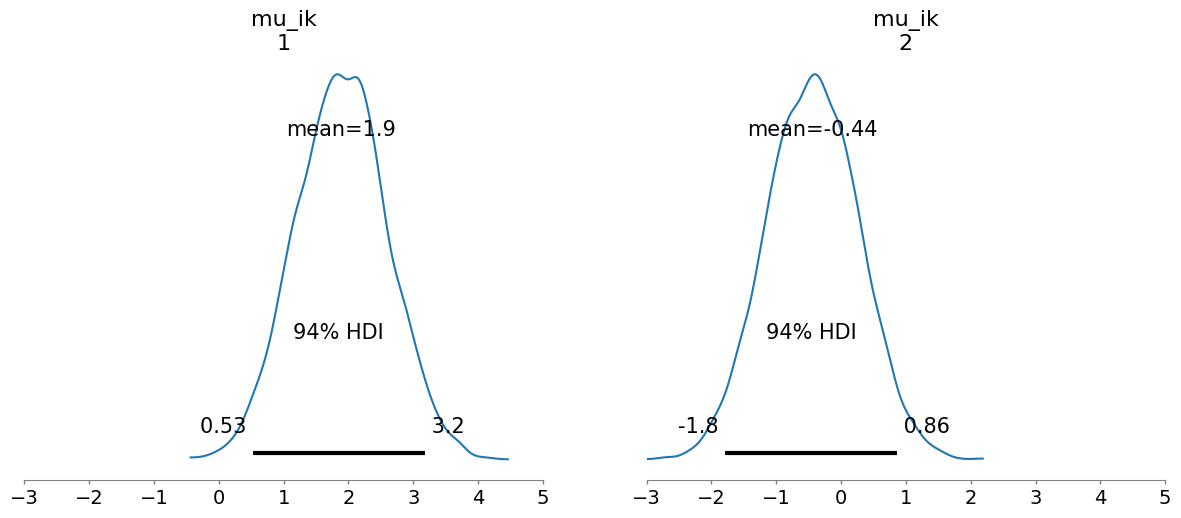

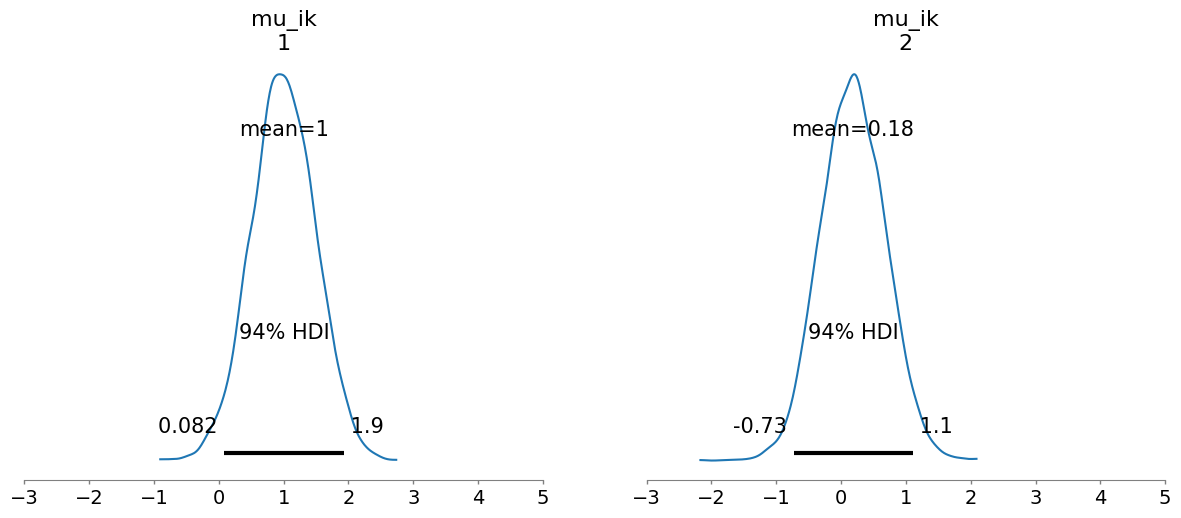

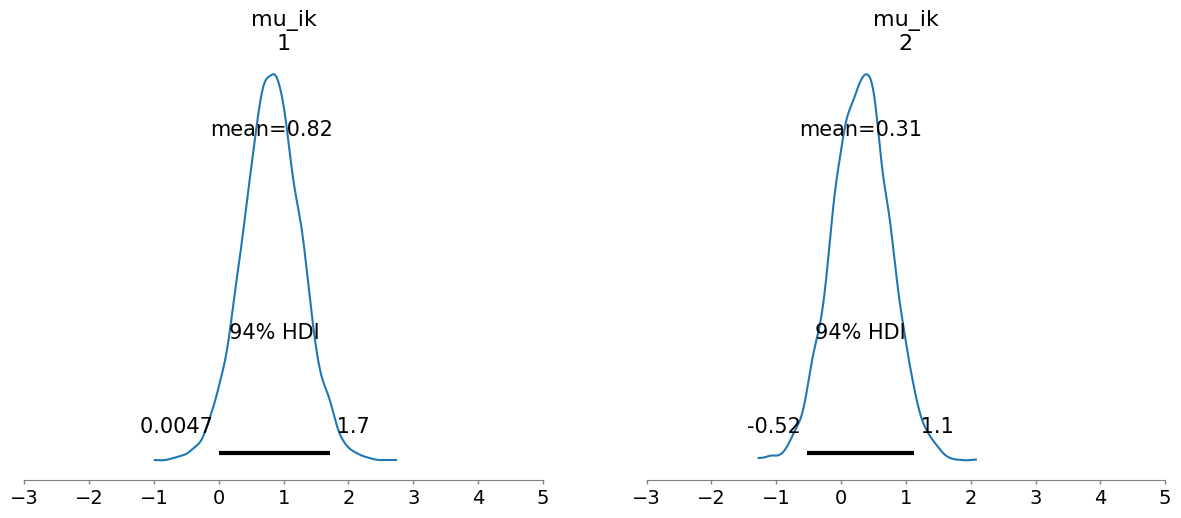

In [22]:
# Wide gaussian
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 <= l]
    model = pymc.Model()
    with model:
        intervention_index = pymc.MutableData(
            "intervention_index",
            pymc.intX(shortened_df["intervention"] - 1),
            dims="observation",
        )
        patient_index = 0
        mu_ik = pymc.Normal("mu_ik", mu=0, sigma=10, dims="intervention", shape=2)
        outcome = pymc.Normal(
            "outcome",
            mu=mu_ik[intervention_index],
            observed=shortened_df[patient_index],
            sigma=1,
            dims="observation",
            shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace, labeller=labeller)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3, 5)

    plt.savefig(
        f"mt_resources/2-background/priors-wide-gaussian-{l}.pdf", bbox_inches="tight"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


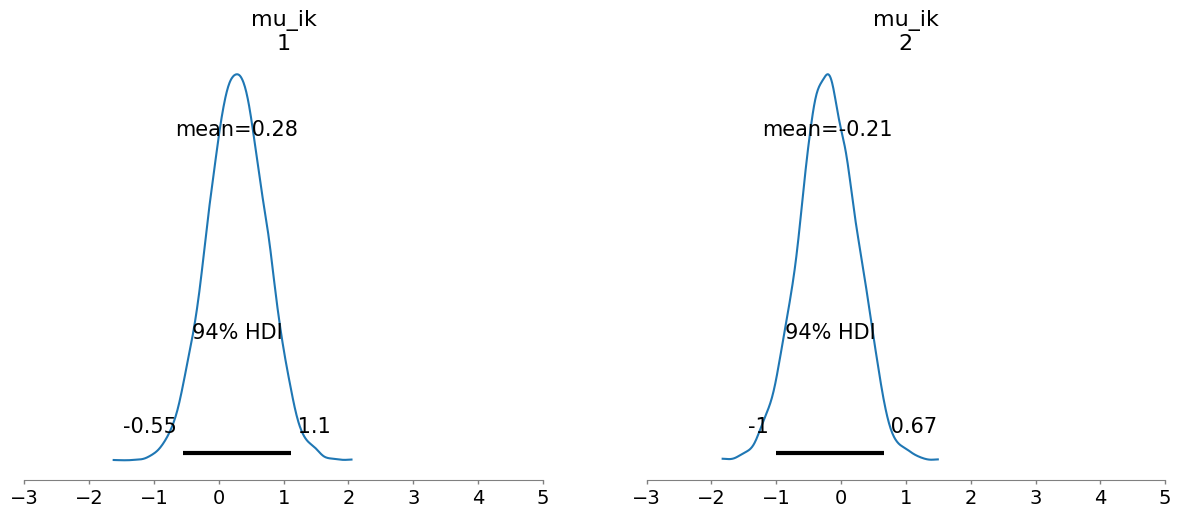

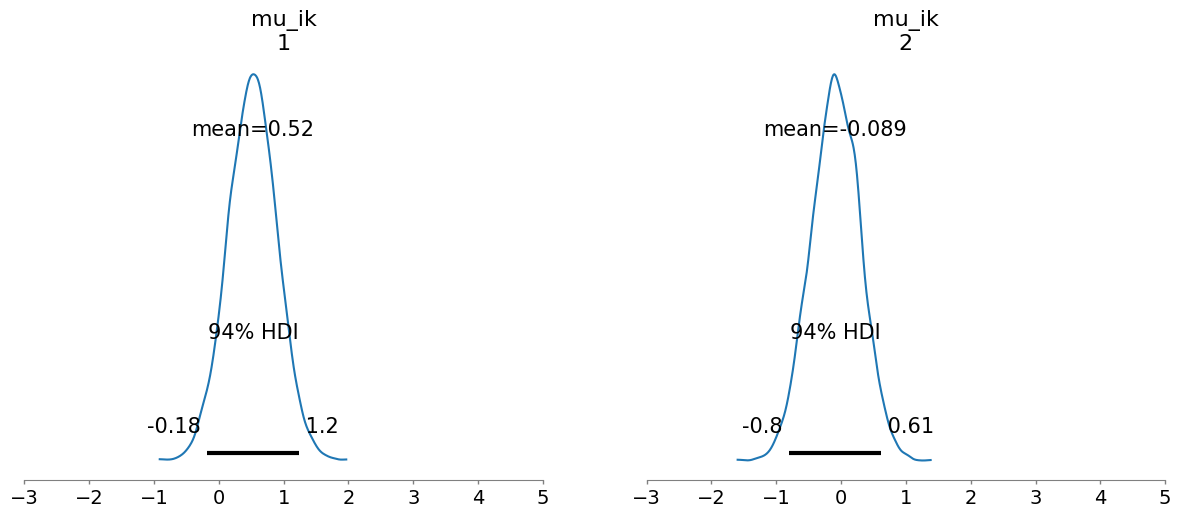

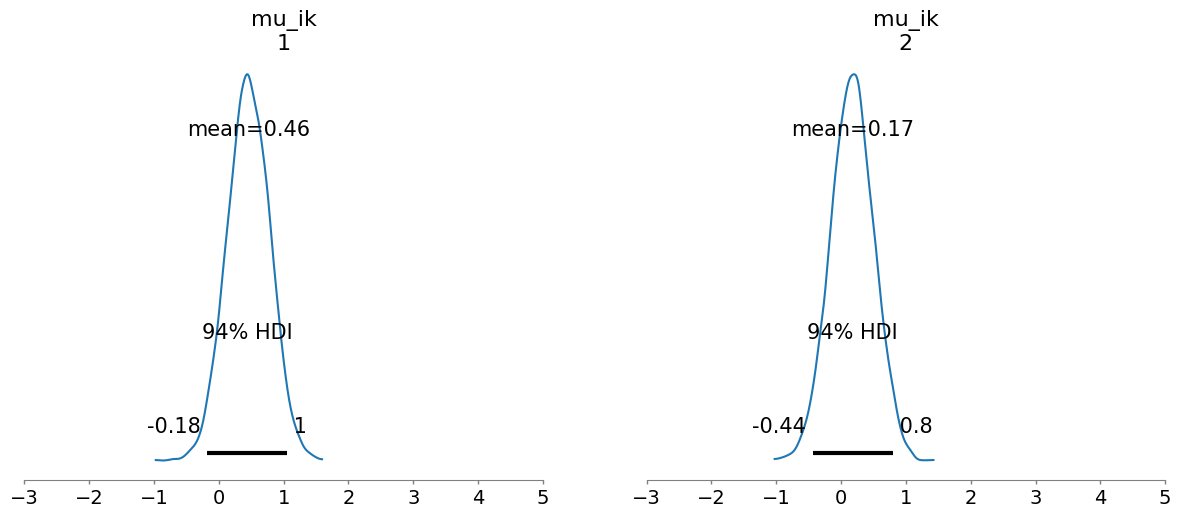

In [23]:
# Narrow gaussian
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        intervention_index = pymc.MutableData(
            "intervention_index",
            pymc.intX(shortened_df["intervention"] - 1),
            dims="observation",
        )
        patient_index = 0
        mu_ik = pymc.Normal("mu_ik", mu=0, sigma=0.5, dims="intervention", shape=2)
        outcome = pymc.Normal(
            "outcome",
            mu=mu_ik[intervention_index],
            observed=shortened_df[patient_index],
            sigma=1,
            dims="observation",
            shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace, labeller=labeller)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3, 5)
    plt.savefig(
        f"mt_resources/2-background/priors-narrow-gaussian-{l}.pdf", bbox_inches="tight"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


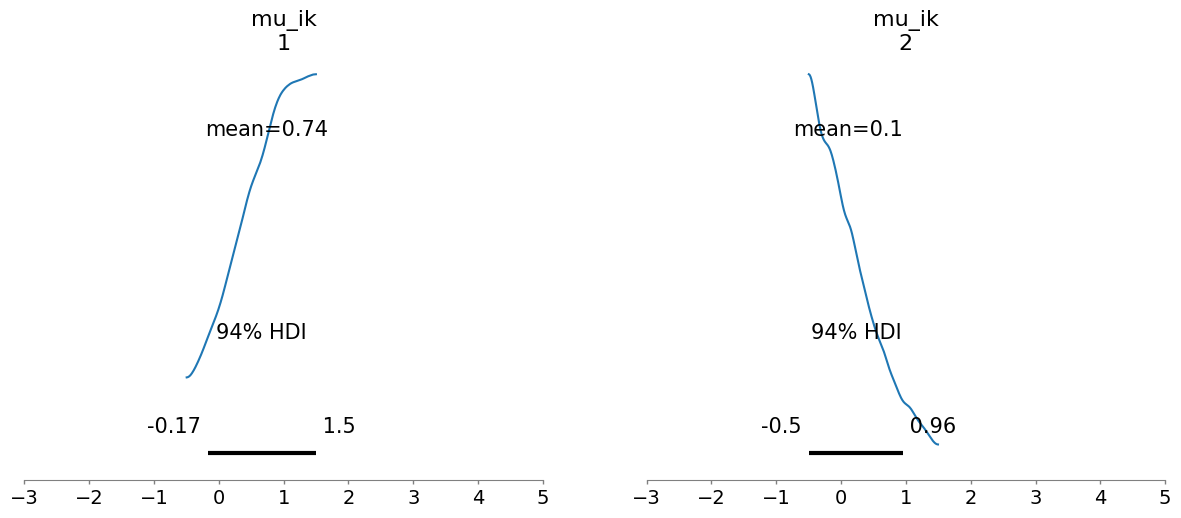

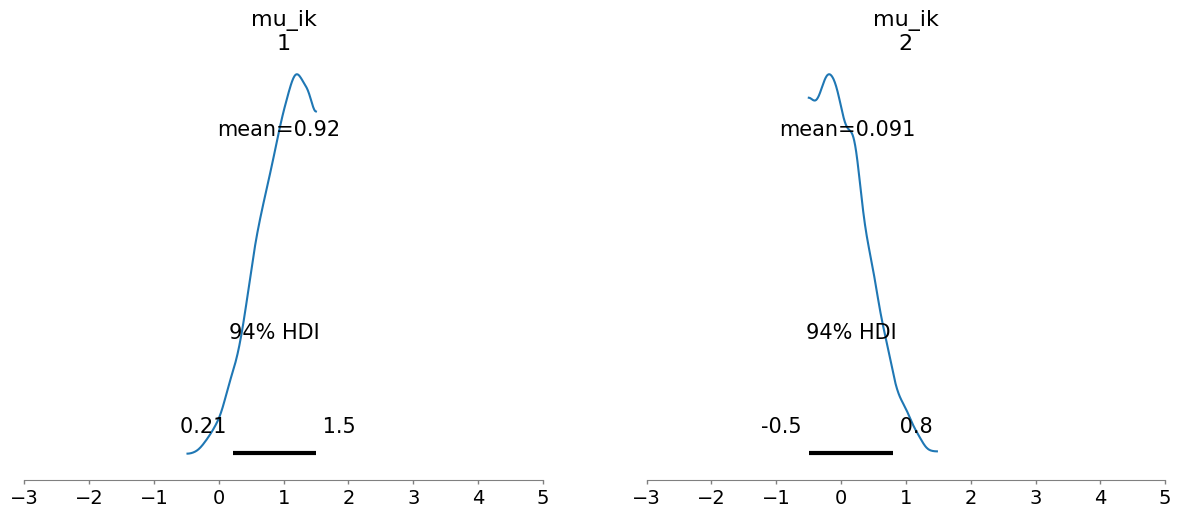

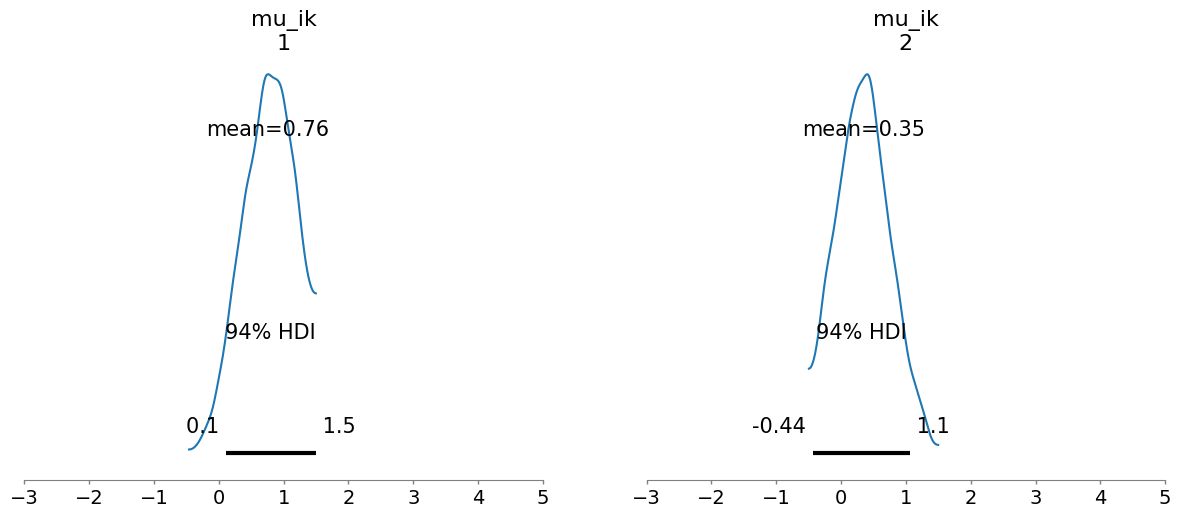

In [24]:
# Narrow Uniform
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        intervention_index = pymc.MutableData(
            "intervention_index",
            pymc.intX(shortened_df["intervention"] - 1),
            dims="observation",
        )
        patient_index = 0
        mu_ik = pymc.Uniform(
            "mu_ik", lower=-0.5, upper=1.5, dims="intervention", shape=2
        )
        outcome = pymc.Normal(
            "outcome",
            mu=mu_ik[intervention_index],
            observed=shortened_df[patient_index],
            sigma=1,
            dims="observation",
            shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace, labeller=labeller)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3, 5)
    plt.savefig(
        f"mt_resources/2-background/priors-narrow-uniform-{l}.pdf", bbox_inches="tight"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ik]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


[<Axes: title={'center': 'mu_ik\n1'}> <Axes: title={'center': 'mu_ik\n2'}>]


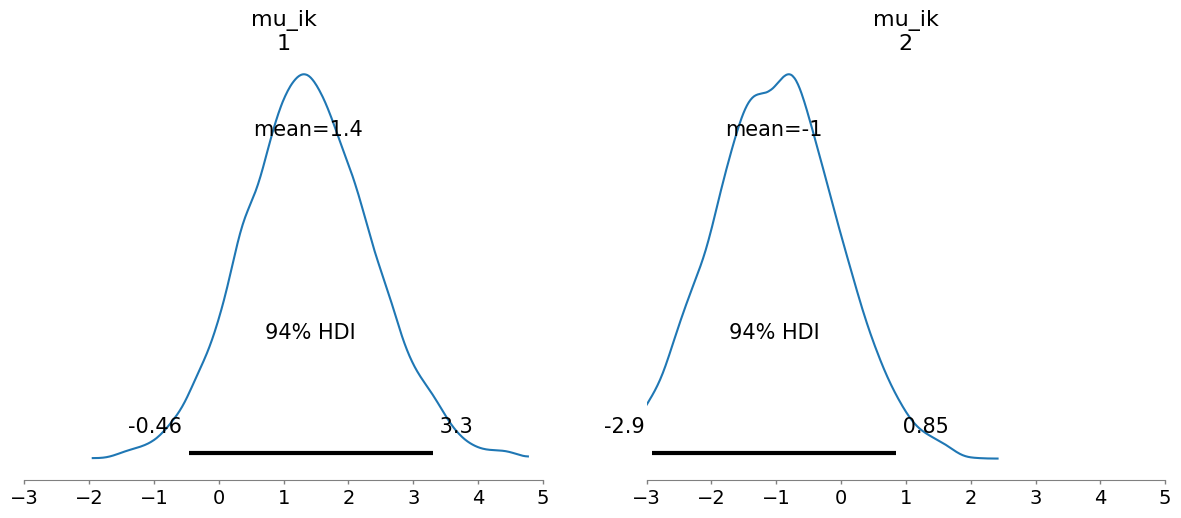

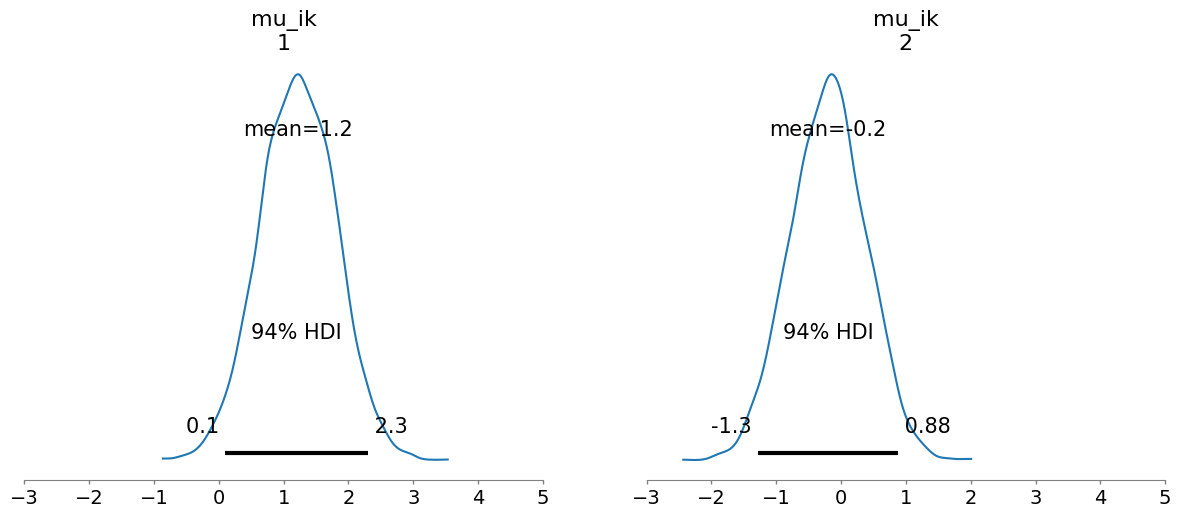

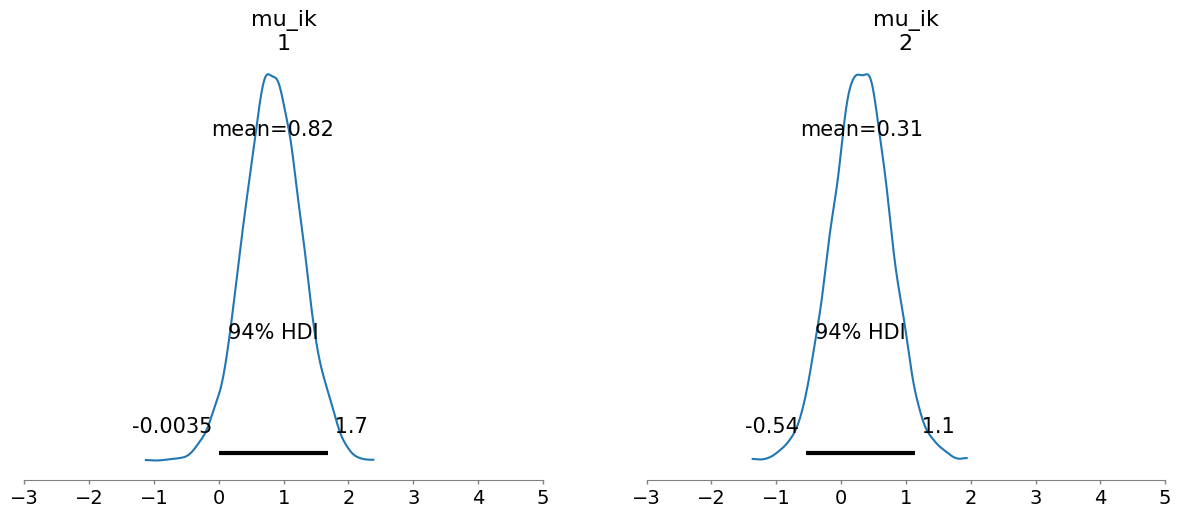

In [25]:
# Wide Uniform
observation_length = [1, 3, 5]
ax = None
for l in observation_length:
    shortened_df = df[df["t"] % 5 < l]
    model = pymc.Model()
    with model:
        intervention_index = pymc.MutableData(
            "intervention_index",
            pymc.intX(shortened_df["intervention"] - 1),
            dims="observation",
        )
        patient_index = 0
        mu_ik = pymc.Uniform("mu_ik", lower=-5, upper=5, dims="intervention", shape=2)
        outcome = pymc.Normal(
            "outcome",
            mu=mu_ik[intervention_index],
            observed=shortened_df[patient_index],
            sigma=1,
            dims="observation",
            shape=len(shortened_df[patient_index]),
        )
        trace = pymc.sample(2000, progressbar=False)
        axes = arviz.plot_posterior(trace, labeller=labeller)
        print(axes)
        for ax in axes:
            ax.set_xlim(-3, 5)
    plt.savefig(
        f"mt_resources/2-background/priors-wide-uniform-{l}.pdf", bbox_inches="tight"
    )